In [1]:
!git clone https://github.com/muxspace/facial_expressions

Cloning into 'facial_expressions'...
remote: Enumerating objects: 14214, done.
remote: Total 14214 (delta 0), reused 0 (delta 0), pack-reused 14214
Receiving objects: 100% (14214/14214), 239.65 MiB | 42.40 MiB/s, done.
Resolving deltas: 100% (223/223), done.
Checking out files: 100% (13996/13996), done.


In [2]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [3]:
!ls

facial_expressions  sample_data


In [4]:
df = pd.read_csv('facial_expressions/data/legend.csv')

In [5]:
df.head()

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,anger
1,628,facial-expressions_2868585k.jpg,surprise
2,628,facial-expressions_2868584k.jpg,disgust
3,628,facial-expressions_2868582k.jpg,fear
4,dwdii,Aaron_Eckhart_0001.jpg,neutral


In [6]:
df['emotion'].unique()

array(['anger', 'surprise', 'disgust', 'fear', 'neutral', 'happiness',
       'sadness', 'contempt', 'NEUTRAL', 'SADNESS', 'DISGUST', 'FEAR',
       'SURPRISE', 'ANGER', 'HAPPINESS'], dtype=object)

In [7]:
df['emotion'] = df['emotion'].replace(['NEUTRAL'],'neutral')
df['emotion'] = df['emotion'].replace(['SADNESS'],'sadness')
df['emotion'] = df['emotion'].replace(['DISGUST'],'disgust')
df['emotion'] = df['emotion'].replace(['FEAR'],'fear')
df['emotion'] = df['emotion'].replace(['SURPRISE'],'surprise')
df['emotion'] = df['emotion'].replace(['ANGER'],'anger')
df['emotion'] = df['emotion'].replace(['HAPPINESS'],'happiness')

In [8]:
df['emotion'].unique()

array(['anger', 'surprise', 'disgust', 'fear', 'neutral', 'happiness',
       'sadness', 'contempt'], dtype=object)

In [9]:
df['emotion'].value_counts()

neutral      6868
happiness    5696
surprise      368
sadness       268
anger         252
disgust       208
fear           21
contempt        9
Name: emotion, dtype: int64

In [10]:
df = df[df['emotion'] != 'surprise']
df['emotion'] = df['emotion'].replace(['anger','sadness','disgust','fear','contempt'],'Angry/Sad')

In [11]:
df['emotion'].value_counts()

neutral      6868
happiness    5696
Angry/Sad     758
Name: emotion, dtype: int64

In [12]:
emotions = df['emotion'].unique()
print(emotions)

['Angry/Sad' 'neutral' 'happiness']


In [13]:
def onehot(string,emotions):
  l = []
  for e in emotions:
    if string == e:
      l.append(1)
    else:
      l.append(0)
  return l        

In [14]:
df.columns

Index(['user.id', 'image', 'emotion'], dtype='object')

In [15]:
df = df.reset_index(drop=True)
df.head()

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,Angry/Sad
1,628,facial-expressions_2868584k.jpg,Angry/Sad
2,628,facial-expressions_2868582k.jpg,Angry/Sad
3,dwdii,Aaron_Eckhart_0001.jpg,neutral
4,302,Aaron_Guiel_0001.jpg,happiness


In [16]:
img_dir = 'facial_expressions/images'

training_data = []

for i in range(len(df)):

  name = df['image'][i]
  emote = df['emotion'][i]

  vec = onehot(emote,emotions)

  img_array = cv2.imread(os.path.join(img_dir,name) ,cv2.IMREAD_GRAYSCALE)
  img_array = cv2.resize(img_array, (100, 100))

  training_data.append([img_array,vec])  

[1, 0, 0]


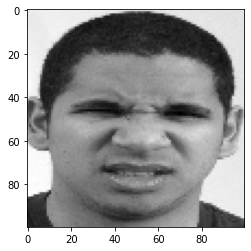

In [17]:
plt.imshow(training_data[1][0], cmap='gray')  # graph it
print(training_data[1][1])
plt.show()  # display!

In [18]:
len(training_data)

13322

In [19]:
import random

random.shuffle(training_data)

train_data = training_data[:13000] 
test_data = training_data[13000:]


In [20]:
X = []
Y = []
for features,label in train_data:
    X.append(features)
    Y.append(label)
    
Xtest = []
Ytest = []
for features,label in test_data:
    Xtest.append(features)
    Ytest.append(label)

In [21]:
X = np.array(X).reshape(-1, 100, 100, 1)

Y = np.array(Y) 


Xtest = np.array(Xtest).reshape(-1, 100, 100, 1)

Ytest = np.array(Ytest)

In [22]:
X.shape

(13000, 100, 100, 1)

In [23]:
Xtest.shape

(322, 100, 100, 1)

In [24]:
X = X/255.0
Xtest = Xtest/255.0

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [26]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(len(emotions)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
model.fit(X, Y, batch_size=32, epochs=10, validation_split=0.3)

Epoch 1/10
285/285 [==============================] - 26s 65ms/step - loss: 0.8487 - accuracy: 0.5697 - val_loss: 0.5493 - val_accuracy: 0.8015
Epoch 2/10
285/285 [==============================] - 18s 62ms/step - loss: 0.5286 - accuracy: 0.7923 - val_loss: 0.5110 - val_accuracy: 0.8095
Epoch 3/10
285/285 [==============================] - 18s 62ms/step - loss: 0.4978 - accuracy: 0.8038 - val_loss: 0.4885 - val_accuracy: 0.8115
Epoch 4/10
285/285 [==============================] - 18s 62ms/step - loss: 0.4497 - accuracy: 0.8223 - val_loss: 0.4955 - val_accuracy: 0.8064
Epoch 5/10
285/285 [==============================] - 18s 62ms/step - loss: 0.3943 - accuracy: 0.8411 - val_loss: 0.5490 - val_accuracy: 0.7764
Epoch 6/10
285/285 [==============================] - 18s 62ms/step - loss: 0.3578 - accuracy: 0.8566 - val_loss: 0.5087 - val_accuracy: 0.8008
Epoch 7/10
285/285 [==============================] - 18s 62ms/step - loss: 0.3289 - accuracy: 0.8716 - val_loss: 0.4809 - val_accuracy:

In [28]:
val_loss, val_acc = model.evaluate(Xtest, Ytest)
print(val_loss)
print(val_acc)

11/11 [==============================] - 0s 26ms/step - loss: 0.5411 - accuracy: 0.8416
0.541074812412262
0.8416149020195007


In [29]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")